Note: for the next block to run, you should manually [download](https://drive.google.com/open?id=0B_tExHiYS-0veklUZHFYT19KYjg) the MNIST-M dataset and unpack it into data_dir.

- paper - https://arxiv.org/pdf/1505.07818.pdf
- code pieces were taken from Technion cs236781

In [1]:
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

import math
import torchvision as tv
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as tvtf


In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from src.data import MNISTMDataset
from src.plot_utils import dataset_first_n

image_size = 28
batch_size = 4
tf_source = tvtf.Compose([ tvtf.Resize(image_size), tvtf.ToTensor(), tvtf.Normalize(mean=(0.1307,), std=(0.3081,)) ])
tf_target = tvtf.Compose([
    tvtf.Resize(image_size), tvtf.ToTensor(), tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

ds_source = tv.datasets.MNIST(root=data_dir, train=True, transform=tf_source, download=True)

# Custom PyTorch Dataset class to load MNIST-M
ds_target = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                         transform=tf_target)

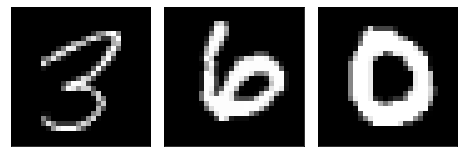

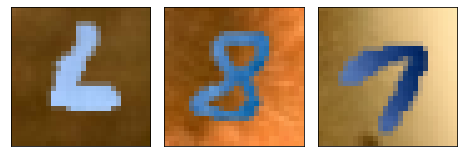

In [4]:
# Show a few random images from each dataset
dataset_first_n(ds_source, 3, cmap='gray', random_start=True);
dataset_first_n(ds_target, 3, random_start=True);

In [5]:
# Dataloaders
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

In [6]:
from torch.autograd import Function

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, λ):
        # Store context for backprop
        ctx.λ = λ
        
        # Forward pass is a no-op
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # grad_output is dL/dx (since our forward's output was x)
        
        # Backward pass is just to apply -λ to the gradient
        # This will become the new dL/dx in the rest of the network
        output =  - ctx.λ * grad_output

        # Must return number of inputs to forward()
        return output, None

In [7]:
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=1, stride=1),  # (28+2P-F)/S + 1 = 26
            nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(True),    # 26 / 2 = 13
            nn.Conv2d(64, 50, kernel_size=5, padding=1, stride=1), # (12+2P-F)/S + 1 = 10
            nn.BatchNorm2d(50), nn.MaxPool2d(2), nn.ReLU(True),    # 10 / 2 = 5
            nn.Dropout2d(),
        )
        self.num_cnn_features = 50 * 5 * 5 # Assuming 28x28 input
        
        self.class_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100), nn.Dropout2d(), nn.ReLU(True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100), nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100), nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x, λ=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features)
        features_grl = GradientReversalFn.apply(features, λ)
        class_pred = self.class_classifier(features)        # classify on regular features
        domain_pred = self.domain_classifier(features_grl)  # classify on features after GRL
        return class_pred, domain_pred

Training

In [8]:
lr = 1e-3
n_epochs = 3

# Setup optimizer as usual
model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Two loss functions this time (can generally be different)
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

batch_size = 256
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))

In [9]:
for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in range(max_batches-1):
        # Calculate training progress and GRL λ
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        λ = 2. / (1. + np.exp(-10 * p)) - 1

        # === Train on source domain
        X_s, y_s = next(dl_source_iter)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels: 0

        class_pred, domain_pred = model(X_s, λ)
        loss_s_label = loss_fn_class(class_pred, y_s)           # source classification loss
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain) # source domain loss (via GRL)

        # === Train on target domain
        X_t, _ = next(dl_target_iter) # Note: ignoring target domain class labels!
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels: 1

        _, domain_pred = model(X_t, λ)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain) # target domain loss (via GRL)
        
        # === Optimize
        loss = loss_t_domain + loss_s_domain + loss_s_label
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'[{batch_idx+1}/{max_batches}] '
                  f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
                  f't_domain_loss: {loss_t_domain.item():.4f} ' f'λ: {λ:.3f} '
                 )


Epoch 0001 / 0003
[1/231] class_loss: 2.3780 s_domain_loss: 0.9973 t_domain_loss: 0.5251 λ: 0.000 
[11/231] class_loss: 1.6282 s_domain_loss: 0.6008 t_domain_loss: 0.7939 λ: 0.072 
[21/231] class_loss: 1.1917 s_domain_loss: 0.6515 t_domain_loss: 0.7227 λ: 0.143 
[31/231] class_loss: 0.9490 s_domain_loss: 0.6949 t_domain_loss: 0.6778 λ: 0.213 
[41/231] class_loss: 0.6218 s_domain_loss: 0.6317 t_domain_loss: 0.7279 λ: 0.281 
[51/231] class_loss: 0.6065 s_domain_loss: 0.6619 t_domain_loss: 0.6984 λ: 0.346 
[61/231] class_loss: 0.4424 s_domain_loss: 0.6592 t_domain_loss: 0.6949 λ: 0.408 
[71/231] class_loss: 0.3487 s_domain_loss: 0.6548 t_domain_loss: 0.6955 λ: 0.466 
[81/231] class_loss: 0.3399 s_domain_loss: 0.6514 t_domain_loss: 0.6737 λ: 0.521 
[91/231] class_loss: 0.2812 s_domain_loss: 0.6279 t_domain_loss: 0.6696 λ: 0.571 
[101/231] class_loss: 0.2513 s_domain_loss: 0.6321 t_domain_loss: 0.6546 λ: 0.618 
[111/231] class_loss: 0.2947 s_domain_loss: 0.6418 t_domain_loss: 0.6460 λ: 0.66